In [20]:
import sys
import csv
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import gender_guesser.detector as gender

from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [9]:
def read_datasets():
    """ Reads users profile from csv files """
    real_users = pd.read_csv("data/users.csv")
    fake_users = pd.read_csv("data/fusers.csv")
    x=pd.concat([real_users,fake_users])
    y=len(fake_users)*[0] + len(real_users)*[1]
    return x,y

In [44]:
def predict_sex(name):
    d = gender.Detector(case_sensitive=False)
    first_name= str(name).split(' ')[0]
    sex = d.get_gender(u"{}".format(first_name))
    
    sex_code_dict = {'female': -2, 'mostly_female': -1,'unknown':0, 'andy': 0, 'mostly_male':1, 'male': 2}
    sex_code = sex_code_dict[sex]
    
    return sex_code

In [55]:
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))
    
    lang_dict = { name : i for i, name in lang_list }             
    
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)    
    x.loc[:,'sex_code'] = predict_sex(x['name'])
    
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
    x=x.loc[:,feature_columns_to_use]
    
    return x

In [48]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [49]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [50]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print("False Positive rate: ",false_positive_rate)
    print("True Positive rate: ",true_positive_rate)
    
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [102]:
def train(X_train,y_train,X_test):
    """ Trains and predicts dataset with a SVM classifier """
    # Scaling features
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)

    Cs = 10.0 ** np.arange(-2,3,.5)
    gammas = 10.0 ** np.arange(-2,3,.5)
    param = [{'gamma': gammas, 'C': Cs}]
    
    cvk = StratifiedKFold(n_splits=5)
    
    classifier = SVC()
    
    clf = GridSearchCV(classifier, param_grid=param, cv=cvk)
    clf.fit(X_train,y_train)
    
    print("The best classifier is: ", clf.best_estimator_)
    clf.best_estimator_.fit(X_train, y_train)
    
    print()
    
    # Estimate score
    scores = cross_validate(clf.best_estimator_, X_train,y_train, cv=5)
    
    for k in [*scores]:
        print(k + ": ", scores[k])
    
    print()
    
    print("Mean Training Score: {}".format(scores['train_score'].mean()))
    print("Mean Test Score: {}".format(scores['test_score'].mean()))
    
    title = 'Learning Curves (SVM, rbf kernel, $\gamma=%.6f$)' %clf.best_estimator_.gamma
    
    plot_learning_curve(clf.best_estimator_, title, X_train, y_train, cv=5)
    plt.show()
    
    # Predict class
    y_pred = clf.best_estimator_.predict(X_test)
    return y_test,y_pred

In [103]:
x,y = read_datasets()
print("dataset read complete")

dataset read complete


In [104]:
x = extract_features(x)
print(x.columns)

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'sex_code', 'lang_code'],
      dtype='object')


In [105]:
# splitting train and test data
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.20, random_state=44)

/home/junaid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.
/home/junaid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  """


The best classifier is:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=100.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

fit_time:  [0.0908041  0.08225965 0.13456011 0.10009265 0.09038615]
score_time:  [0.01178718 0.0161798  0.01540518 0.01542616 0.01291323]
test_score:  [0.92239468 0.92904656 0.93569845 0.9556541  0.94444444]
train_score:  [0.96783139 0.96727676 0.96561287 0.96561287 0.9672949 ]

Mean Training Score: 0.9667257576372468
Mean Test Score: 0.9374476472037447


/home/junaid/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


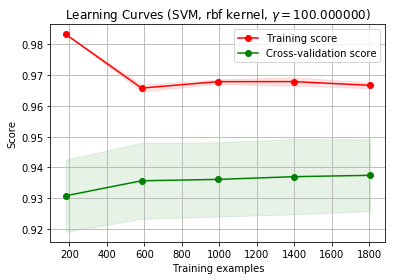

In [106]:
y_test,y_pred = train(X_train,y_train,X_test)